# Protein Trap Rater Comparison

Brian has asked that I look at the intra rater variabilty for scoring protein trap images. Scores are categorical with possible values being {0, 2.5, 5.0, 7.5}, there are also a number of scores that were missing "-" in the document.

**Summary:** Inter-rater scores are highly variable and according to Fleiss Kappa (measure of agreement) agreement is slight. Rank correlation (Kendall's tau) lower for Cyst Cells and Pigment Cells, suggesting that some cell types are more difficult to score. 

In [110]:
import os
import sys
import re
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb

# Settings
pd.options.display.max_rows = 200

In [111]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2018-11-23 
Git hash:


In [161]:
scores = pd.read_csv('../data/external/miriam/ptrap_scores_by_rater.tsv', sep='\t', index_col=0, na_values='-')

# Add on a rater number
scores_w_rater = []
for g, dd in scores.groupby('ptrap_id'):
    _curr = dd.copy()
    _curr['rater'] = range(1, dd.shape[0] + 1)
    scores_w_rater.append(_curr)
    
clusters = ['Spermatogoina', 'Early 1° Spermatocytes', 'Mid 1° Spermatocytes', 'Late 1° Spermatocytes', 'Cyst Cells', 'Pigment Cells', 'Terminal Epithelium']
scores_w_rater = pd.concat(scores_w_rater)
scores_w_rater = scores_w_rater[['ptrap_id', 'rater'] + clusters]
scores_w_rater

,ptrap_id,rater,Spermatogoina,Early 1° Spermatocytes,Mid 1° Spermatocytes,Late 1° Spermatocytes,Cyst Cells,Pigment Cells,Terminal Epithelium
FBgn,,,,,,,,,
FBgn0264975,11_6844,1,5.0,5.0,5.0,5.0,7.5,7.5,7.5
FBgn0264975,11_6844,2,5.0,0.0,0.0,0.0,5.0,NaN,7.5
FBgn0264975,11_6844,3,5.0,2.5,2.5,2.5,2.5,0.0,5.0
FBgn0264975,11_6844,4,0.0,0.0,0.0,0.0,7.5,2.5,7.5
FBgn0030520,12_38446,1,7.5,7.5,7.5,7.5,7.5,NaN,7.5
FBgn0030520,12_38446,2,7.5,5.0,5.0,5.0,7.5,0.0,7.5
FBgn0030520,12_38446,3,7.5,7.5,5.0,2.5,5.0,0.0,7.5
FBgn0030520,12_38446,4,7.5,7.5,7.5,7.5,7.5,7.5,7.5
FBgn0015609,1_39639,1,0.0,0.0,5.0,7.5,0.0,0.0,0.0


## General Rater Variability

I begin by graphically looking at scores by ptrap for each rater. My interpretation is that we cannot quantify an absence of expression with protein traps, therefore 0's are really missing as well. I set all missing values to 0. There is a lot of variation here, with examples of one rater scoring it as 0/NaN and another as 5 or 7.5 (see first plot, pigment cells). 

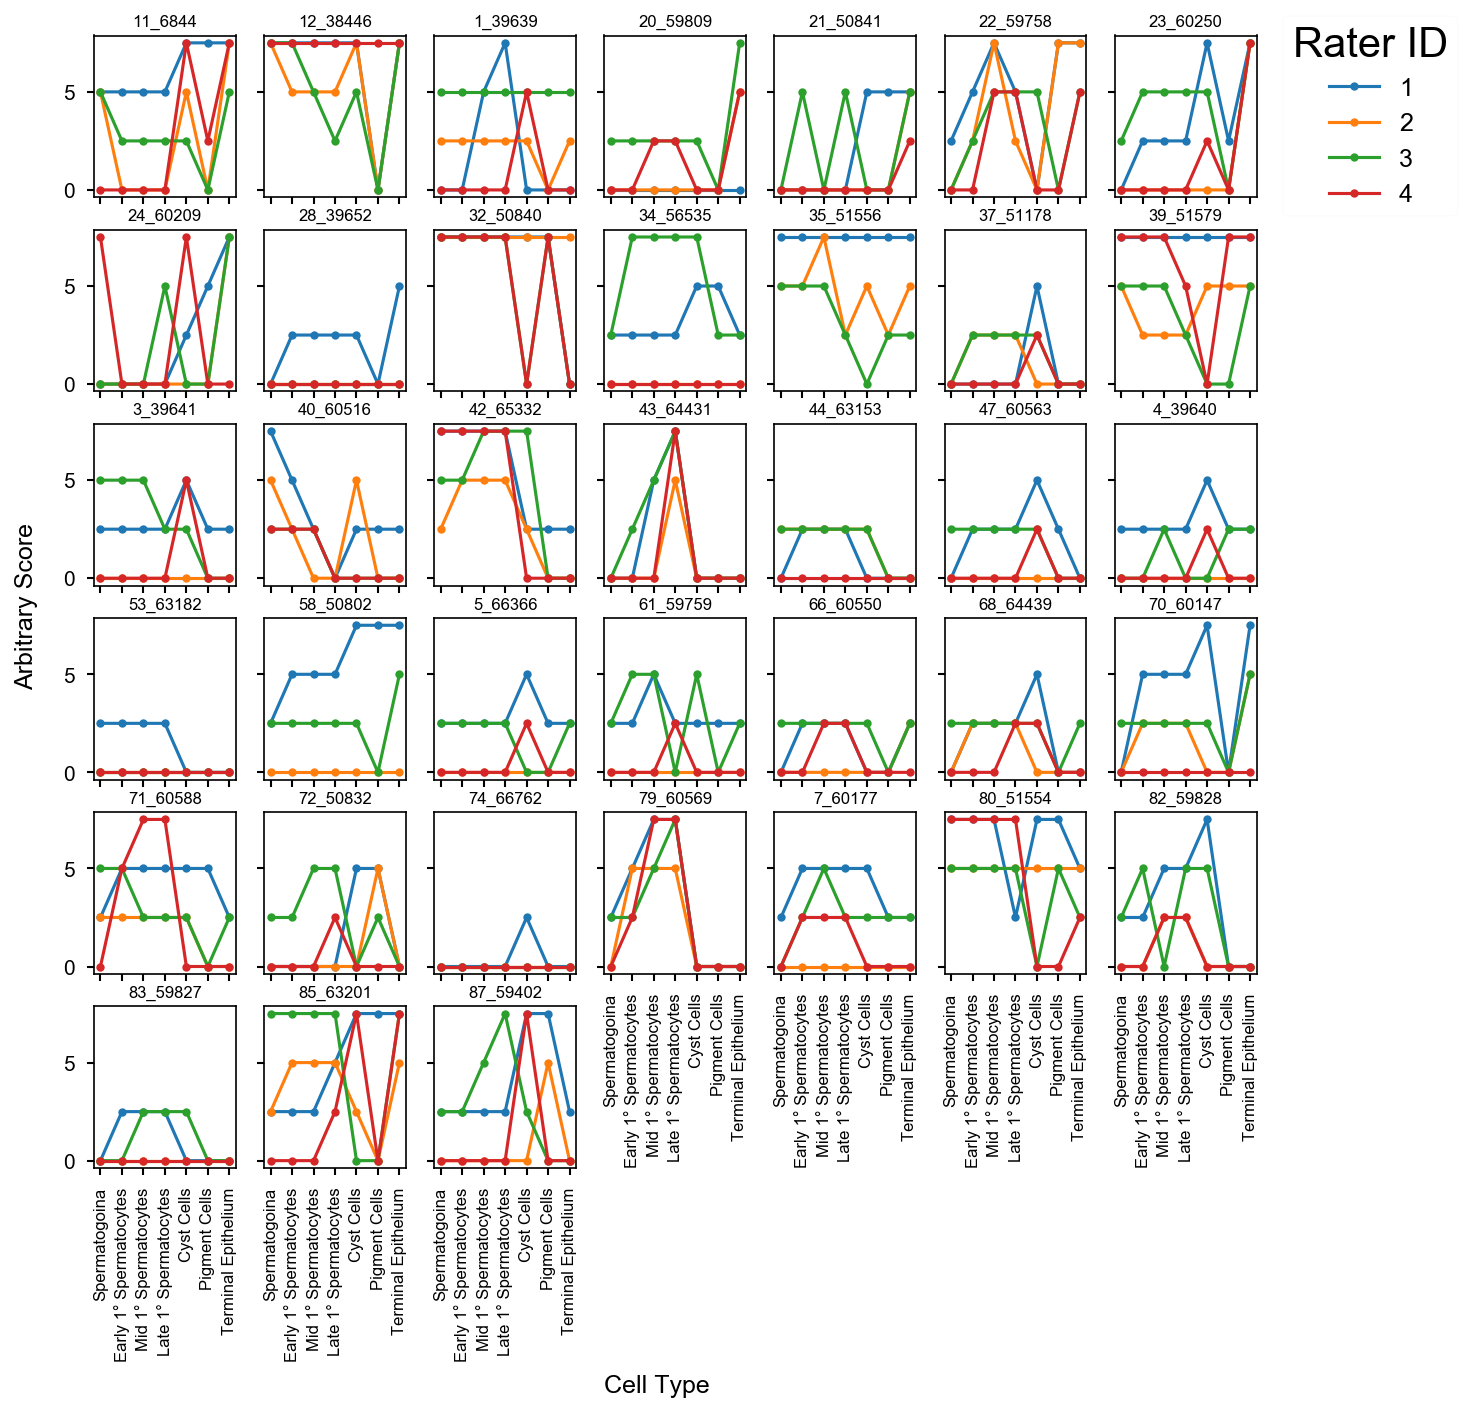

In [115]:
fig, axes = plt.subplots(6, 7, sharey=True, figsize=(10, 10))

for ax, (g, dd) in zip(axes.flat, scores_w_rater.groupby('ptrap_id')):
    _dat = dd.iloc[:, 1:].set_index('rater').T.fillna(0)
    _dat.plot(marker='.', ax=ax, legend=False)
    ax.set_xticks(range(0, _dat.shape[0]))
    ax.set_xticklabels(_dat.index.tolist(), fontsize=8, rotation=90);
    ax.set_title('{}'.format(g), fontsize=8, y=.98)
    
for ax in axes[-1, -4:].flat:
    ax.set_visible(False)
    
for ax in axes[:4, :].flat:
    ax.set_xticklabels([])
    
for ax in axes[4, :-4].flat:
    ax.set_xticklabels([])
    
axes[0, -1].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), title='Rater ID');
fig.text(0.08, 0.5, 'Arbitrary Score', fontsize=12, rotation=90, ha='center', va='center')
fig.text(0.5, -0.02, 'Cell Type', fontsize=12, ha='center', va='center');

## Rank correlation

Next I look at rank correlation using Kendall's tau. Mean correlation by cluster is pretty low (≤ 0.6). In particular, Cyst cells and Pigment cells show really low correlation across protein traps.  

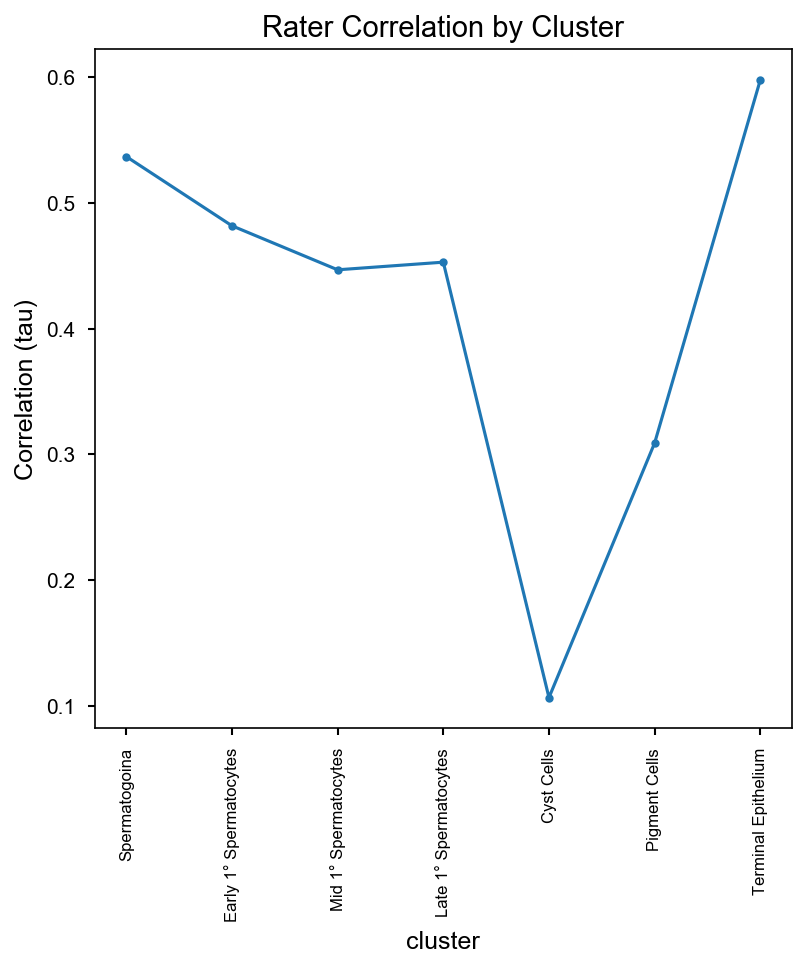

In [183]:
melted = scores_w_rater.melt(id_vars=['ptrap_id', 'rater'], value_name='score', var_name='cluster')

res = []
for g, dd in melted.groupby('cluster'):
    curr = dd.copy()
    curr.set_index(['ptrap_id', 'rater'], inplace=True)
    curr.drop('cluster', axis=1, inplace=True)

    dat = curr.unstack().fillna(0)
    _corr = dat.corr(method='kendall')
    keep = np.triu(np.ones(_corr.shape), k=1).astype('bool').reshape(_corr.size)
    _mean_corr = _corr.stack().loc[keep, 'score'].mean()
    res.append((g, _mean_corr))
   

summary = pd.DataFrame(res, columns=['cluster', 'tau']).set_index('cluster').reindex(clusters)

ax = summary.plot(marker='.', legend=False)
ax.set_xticks(range(summary.shape[0]))
ax.set_xticklabels(summary.index.tolist(), rotation=90, size=8)
ax.set_ylabel("Correlation (tau)")
ax.set_title('Rater Correlation by Cluster');

## Inter-rater agreement

There are several different metrics to look at inter-rater agreement. The most popular is Cohen's Kappa. This metric can only compare rater in a pairwise fashion. 

General rules of thumb regarding kappa:

|kappa|Agreement|
|-----|---------|
|<0|Less than chance agreement|
|0.01-0.20|Slight agreement|
|0.21-0.40|Fair agreement|
|0.41-0.60|Moderate agreement|
|0.61-0.80|Substantial agreement|
|0.81-0.99|Almost perfect agreement|

Using this scale, the majority of our raters have "Slight agreement" with raters 2 & 3 and 2 & 4 having "Fair agreement.

In [224]:
from sklearn.metrics import cohen_kappa_score

melted = scores_w_rater.melt(id_vars=['ptrap_id', 'rater'], value_name='score', var_name='cluster').set_index(['ptrap_id', 'cluster', 'rater'])
unstacked = melted.unstack().fillna(0)
unstacked.columns = unstacked.columns.droplevel(0)

mapper = {
    0: 0,
    2.5: 1,
    5.0: 2,
    7.5: 3
}

unstacked = unstacked.applymap(lambda x: mapper[x])

kappas = {
    "r1 vs r2": cohen_kappa_score(unstacked[1], unstacked[2]),
    "r1 vs r3": cohen_kappa_score(unstacked[1], unstacked[3]),
    "r1 vs r4": cohen_kappa_score(unstacked[1], unstacked[4]),
    "r2 vs r3": cohen_kappa_score(unstacked[2], unstacked[3]),
    "r2 vs r4": cohen_kappa_score(unstacked[2], unstacked[4]),
    "r3 vs r4": cohen_kappa_score(unstacked[3], unstacked[4]),
}

_df = pd.Series(kappas).to_frame()
_df.columns = ['kappa']
_df.index.name = 'comparison'
_df

,kappa
comparison,
r1 vs r2,0.126369
r1 vs r3,0.163829
r1 vs r4,0.181220
r2 vs r3,0.243963
r2 vs r4,0.237694
r3 vs r4,0.184414


### Fleiss kappa

A multi-rater version of Cohen's kappa to avoid having to do the pairwise comparisons. However, Fleiss's kappa requires that all raters have scored all protein traps. Rater 4 only scores 36 (of 38) protein traps. I am removing the 2 missing protein trap scores from the comparison. Fleiss kappa also only shows slight agreement with k ~= 0.18

In [287]:
from statsmodels.stats.inter_rater import fleiss_kappa
# Figure out which ptraps have missing scores
missing = []
for g, dd in scores_w_rater.groupby('ptrap_id'):
    if dd.shape[0] < 4:
        missing.append(g)

scores_w_rater_short = scores_w_rater.query(f'ptrap_id != {missing}')

# Cross tabulate scores so rows are ptrap * cluster, columns are score values {0, 2.5, 5.0, 7.5}, and values are number of rates that scored.
_dat = scores_w_rater_short.fillna(0).melt(id_vars=['ptrap_id', 'rater'], var_name='cluster', value_name='score')

ctab = _dat.groupby(['ptrap_id', 'cluster', 'score']).size().unstack().fillna(0)

fleiss_kappa(ctab.values)

0.17993315844323848

If we remove rater 1's, agreement is better ~0.21

In [291]:
from statsmodels.stats.inter_rater import fleiss_kappa
# Figure out which ptraps have missing scores
missing = []
for g, dd in scores_w_rater.query('rater != 1').groupby('ptrap_id'):
    if dd.shape[0] < 3:
        missing.append(g)

scores_w_rater_short = scores_w_rater.query('rater != 1').query(f'ptrap_id != {missing}')

# Cross tabulate scores so rows are ptrap * cluster, columns are score values {0, 2.5, 5.0, 7.5}, and values are number of rates that scored.
_dat = scores_w_rater_short.fillna(0).melt(id_vars=['ptrap_id', 'rater'], var_name='cluster', value_name='score')

ctab = _dat.groupby(['ptrap_id', 'cluster', 'score']).size().unstack().fillna(0)

fleiss_kappa(ctab.values)

0.2060702230172238